In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from __init__ import *
import numpy as np
from export.saver import read_pickle
from helpers.layout import Layout
from helpers.graph_helpers import *
from helpers.helpers import sort_and_group_objects
from typing import Dict
from domains.domain import Domain
from helpers.directions import get_axis, get_opposite_axis, Direction
from placement.arrange import *
from placement.place import *
from copy import copy, deepcopy
from icecream import ic
from visuals.plotter import plot_general
from itertools import product, combinations
from fixes.reporter import Reporter
from new_solutions.selection import Cook
from domains.range import Range
from new_solutions.interfaces import ResultsLog
from fixes.problem_types.overlap_id import *
from read.svg_reader import SVGReader
from adjacencies.adjacency import AdjacencyGenerator

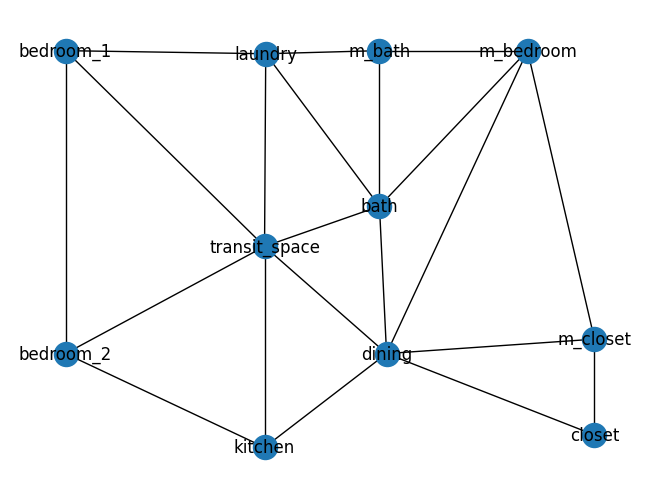

In [5]:
case  = "amber_a_f01.svg"
sv = SVGReader(case)
sv.run()
ag = AdjacencyGenerator(sv.layout, buffer_size=0.17)
ag.run() # TODO shouldnt run if sv.layout is empty
ag.draw_graph()

In [6]:
G = ag.layout.graph
arr = initialize_arr(ag.layout)
graph_domains = GraphDomains(G, ag.layout.domains)
arr

array([['bedroom_1', 'laundry', 'm_bath', 'm_bedroom'],
       ['bedroom_2', '', '', '']], dtype=object)

In [7]:
arr1 = place_next_row(graph_domains, arr)
arr1

arrange> nodes with north AND east relationships for members of row 1: ['m_bedroom']


array([['bedroom_1', 'laundry', 'm_bath', 'm_bedroom'],
       ['bedroom_2', 'transit_space', 'bath', 'm_bedroom']], dtype=object)

In [8]:
arr2  = place_next_row(graph_domains, arr1)
arr2

array([['bedroom_1', 'laundry', 'm_bath', 'm_bedroom'],
       ['bedroom_2', 'transit_space', 'bath', 'm_bedroom'],
       ['bedroom_2', 'kitchen', 'dining', 'm_closet']], dtype=object)

In [9]:
arr3  = place_next_row(graph_domains, arr2)
arr3

array([['bedroom_1', 'laundry', 'm_bath', 'm_bedroom'],
       ['bedroom_2', 'transit_space', 'bath', 'm_bedroom'],
       ['bedroom_2', 'kitchen', 'dining', 'm_closet'],
       ['bedroom_2', '', '', '']], dtype=object)

In [10]:
unplaced = get_unplaced(arr3, graph_domains.domains)
unplaced

{'closet'}

In [11]:
handle_unplaced(graph_domains, arr3)

array([['bedroom_1', 'laundry', 'm_bath', 'm_bedroom'],
       ['bedroom_2', 'transit_space', 'bath', 'm_bedroom'],
       ['bedroom_2', 'kitchen', 'dining', 'm_closet'],
       ['bedroom_2', '', '', 'closet']], dtype=object)

In [51]:
def is_sharing_north_nb(G, curr_node, west_node):
   curr =  set(G.nodes[curr_node]["data"]["NORTH"])
   west = set(G.nodes[west_node]["data"]["NORTH"])
   return bool(curr.intersection(west))

In [52]:
is_sharing_north_nb(graph_domains.G, "closet", "bedroom_2")

False

In [53]:
def is_west_nb(G, curr_node, west_node):
    return west_node in G.nodes[curr_node]["data"]["WEST"]

In [54]:
is_west_nb(graph_domains.G, "closet", "bedroom_2")

False

In [46]:
graph_domains.G.nodes["closet"]

{'data': NeighborDirections(NORTH=['m_closet'], SOUTH=[], EAST=[], WEST=['dining'])}

In [45]:
possible_nodes = get_possible_members_of_next_row(G, arr3, 2)
found_nodes = "bedroom_2"

IndexError: index 3 is out of bounds for axis 0 with size 2